In [1]:
import rioxarray
import numpy as np
import pandas as pd
from datascience import *   
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime 
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint
import joblib
from scipy.stats import uniform
from xgboost import plot_importance
import matplotlib.colors as mcolors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.utils import resample
from scipy import stats

In [2]:
HEIGHT = 90
WIDTH = 250
# all_data = [[[] for _ in range(WIDTH)] for _ in range(HEIGHT)]
m4_y19 = [[[] for _ in range(WIDTH)] for _ in range(HEIGHT)]
m10_y19 = [[[] for _ in range(WIDTH)] for _ in range(HEIGHT)]
m4_y20 = [[[] for _ in range(WIDTH)] for _ in range(HEIGHT)]
m10_y20 = [[[] for _ in range(WIDTH)] for _ in range(HEIGHT)]
cordinates = {}
tmp_name = ['AWS', 'CAPE', 'CIN', 'EWSS', 'IE', 'ISOR', 'KX', 'PEV', 'R250', 'R500', 'R850', 'SLHF', 'SLOR', 'SSHF', 'TCLW', 'TCW', 'TCWV', 'U250', 'U850', 'V250', 'V850']
file_name = [['Precipitation','AWS']]
# opt_file_name = ['AWS', 'CAPE', 'CIN', 'V850', 'KX', 'R250', 'R500', 'U250', 'U850', 'EWSS']
opt_file_name = ['AWS', 'CAPE', 'V850', 'EWSS', 'KX', 'U250', 'U850', 'CIN', 'V250', 'R250']
# opt_file_name = ['AWS']
opt_file_name_path = [['Precipitation','AWS']]
for i in range(1,len(tmp_name)):
    file_name.append(['ERA5',tmp_name[i]])
for i in range(1,len(opt_file_name)):
    opt_file_name_path.append(['ERA5',opt_file_name[i]])
# file_name

Hàm lấy các tọa độ có dữ liệu AWS

In [3]:
def get_AWS_cordinates(hour_list, day_list, month_list, year_list, cordinates):
    for year in year_list:
        for month in month_list:
            for day in day_list:
                for hour in hour_list:
                    file_path = f'DATA_SV/Precipitation/AWS/{year}/{month:02}/{day:02}/AWS_{year}{month:02}{day:02}{hour:02}0000.tif'
                    path = Path(file_path)
                    if not path.is_file():
                        continue
                    dataset = rioxarray.open_rasterio(file_path)
                    data = dataset[0].values
                    for i in range(HEIGHT):
                        for j in range(WIDTH):
                            if data[i][j] != -np.inf:
                                cordinates[(i,j)] = True
                                # print(i,j)
    cordinates = sorted(cordinates)

Hàm đọc dữ liệu

In [4]:

def read(hour, day, month, year, file, cordinates, all_data):
    data = []
    for i in range(len(file)):
        name1 = file[i][0]
        name2 = file[i][1]
        file_path = f'DATA_SV/{name1}/{name2}/{year}/{month:02}/{day:02}/{name2}_{year}{month:02}{day:02}{hour:02}0000.tif'
        # print(file_path)
        path = Path(file_path)
        if not path.is_file():
            return
        # print(file_path)
        dataset = rioxarray.open_rasterio(file_path)
        data.append(dataset[0].values)
        
    # print(len(data))
    if(data != []): 
        for pos in cordinates:
            i = pos[0]
            j = pos[1]
            check = True
            tmp = [datetime(year,month,day,hour)]
            for z in range(len(data)):
                if(data[z][i][j] == -np.inf or data[z][i][j] == np.inf or data[z][i][j] == np.nan):
                    check = False
                    break
                tmp.append(data[z][i][j])
            if check:
                all_data[i][j].append(tmp)
                # print(all_data[i][j])
    # print(all_data)
            

Đọc dự liệu trong khoảng thời gian định sẵn tại đây. dữ liệu all_data[i][j][z] là tại vị trí i, j có tập giá trị tương ứng tại cùng thời điểm

In [6]:

for i in range(HEIGHT):
    for j in range(WIDTH):
        m4_y19[i][j] = []
        m10_y19[i][j] = []
        m4_y20[i][j] = []
        m10_y20[i][j] = []
cordinates.clear
# hour = [0]
hour = [i for i in range(24)]
# day = [1]
# day = [i for i in range(27,28)]
day = [i for i in range(1,32)]
# month = [4]
month = [4,10]
# year = [2019] 
year = [2019,2020]
get_AWS_cordinates(hour, day, month, year, cordinates)
cordinates_list = list(cordinates)
for k in day:
    for l in hour:
        read(l, k, month[0], year[0], file_name, cordinates_list, m4_y19)
        read(l, k, month[1], year[0], file_name, cordinates_list, m10_y19)
        read(l, k, month[0], year[1], file_name, cordinates_list, m4_y20)
        read(l, k, month[1], year[1], file_name, cordinates_list, m10_y20)
# print(len(cordinates_list))

In [100]:
all_data = []
for (i,j) in cordinates_list:
    for data in m4_y19[i][j]:
        all_data.append([i,j] + data)
    for data in m10_y19[i][j]:
        all_data.append([i,j] + data)
    for data in m4_y20[i][j]:
        all_data.append([i,j] + data)
    for data in m10_y20[i][j]:
        all_data.append([i,j] + data)
print((all_data[0]))
    

[0, 114, datetime.datetime(2019, 4, 1, 0, 0), 0.0, 446.125, 38.875008, -641.11328, -1.3912562e-05, 0.58824843, 37.360176, -1.5529804e-05, 33.599831, 39.494701, 94.882187, -127783.0, 0.019672839, -11962.0, 0.72320557, 49.239563, 48.219376, 25.793488, -3.6066742, 4.5234528, 7.3280945]


Tải dữ liệu ra csv

In [ ]:
print(len(all_data[0]))
df = pd.DataFrame(all_data, columns=['row','column','datetime'] + tmp_name)
df.to_csv('data.csv', index=False)

24


Nếu đã có file data.csv thì đọc từ đây

In [52]:
def clean(column, data):
    # data.head()
    z_score = stats.zscore(data[column])
    data_clean = data[(np.abs(z_score) < 3)]
    return data_clean

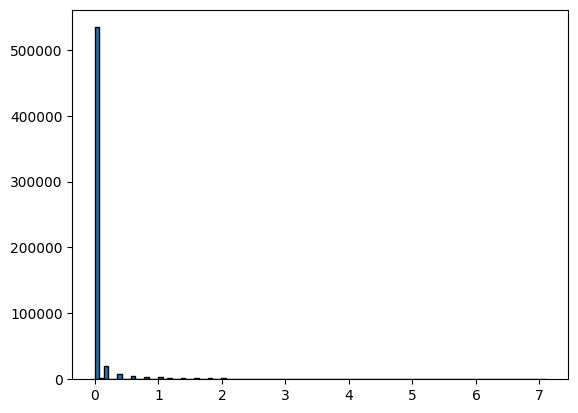

7.1
0.0
(599270, 13)


,row,col,datetime,AWS,CAPE,V850,EWSS,KX,U250,U850,CIN,V250,R250
0,0,104,2020-10-01 00:00:00,0.0,197.250,3.68979,-113.0550,36.6214,-5.80037,-0.907883,61.9535,-0.157303,68.8899
1,0,104,2020-10-01 01:00:00,0.0,138.500,3.51732,-128.2850,36.0785,-5.51169,-0.485977,9999.0000,-0.572311,65.6207
2,0,104,2020-10-01 02:00:00,0.0,102.000,3.18250,-120.6720,35.4105,-4.96336,-0.448380,9999.0000,-1.284910,63.5020
3,0,104,2020-10-01 03:00:00,0.0,160.750,2.46533,-169.1910,34.8431,-4.37927,-0.892761,9999.0000,-2.056780,64.5481
4,0,104,2020-10-01 04:00:00,0.0,204.500,1.55983,-304.3480,34.8934,-3.95996,-1.550840,213.4690,-2.280150,68.5872
...,...,...,...,...,...,...,...,...,...,...,...,...,...
657676,87,136,2020-10-31 19:00:00,7.0,49.000,-1.85147,-80.7422,33.1501,-6.70592,-6.560070,9999.0000,0.735031,36.8900
657677,87,136,2020-10-31 20:00:00,6.0,36.625,-2.38234,-55.3477,33.4893,-7.09450,-5.879990,9999.0000,0.769287,37.0086
657678,87,136,2020-10-31 21:00:00,3.8,43.625,-2.82980,-54.0625,33.4570,-7.56140,-5.307020,9999.0000,0.791824,35.8561
657679,87,136,2020-10-31 22:00:00,2.4,34.875,-3.69713,-50.9336,33.2179,-7.94823,-4.830630,9999.0000,0.880249,32.3189


In [66]:
data_csv = pd.read_csv('data.csv')
data_csv['datetime'] = pd.to_datetime(data_csv['datetime'])
data_csv = data_csv.sort_values(by=['row', 'col'], ascending=[True, True]).reset_index(drop=True)
opt_data_csv = data_csv[['row','col','datetime']+ opt_file_name]
# pt = PowerTransformer(method='yeo-johnson')
for i in opt_file_name:
    # if i == 'AWS':
    #     continue
    opt_data_csv = clean(i,opt_data_csv)
    # opt_data_csv.loc[:,i] = pt.fit_transform(opt_data_csv[[i]])
all_data = opt_data_csv.values
plt.hist(opt_data_csv['AWS'], bins=100)
plt.show()
print(opt_data_csv['AWS'].max())
print(opt_data_csv['AWS'].min())
print(all_data.shape)
opt_data_csv

Xây dựng bộ dữ liệu X,y để cho vào mô hình. 

In [43]:
def create_data(all_data, X, y, num_pre, num_data):
    for z in range(num_pre,int(len(all_data))-num_data+1):
        data = all_data[z:z+num_data]  
        pre_data = all_data[z-num_pre:z]
        check = False
        for k in range(z-num_pre+1,z+num_data):
            # print(all_data[k])
            if int((all_data[k][2] - all_data[k-1][2]).total_seconds()) != 3600:
                check = True
                break
        if check:
            continue
        
        # print(len(pre_data),len(data))
        pre_data = np.array(pre_data)
        data = np.array(data)
        
        # print(pre_data.shape,data.shape)
        # print(pre_data[:,2])
        pre_data = pre_data[:,3:].reshape(-1)
        data = data[:,3].reshape(-1)

        
        X.append(pre_data)
        y.append(data)
    X = np.array(X)
    y = np.array(y)
    # print(X.shape,y.shape)
    return X, y

In [67]:
pre_time_step = 1
aft_time_step = 6

In [68]:
X_train = []
y_train = []
X_test = []
y_test = []

X = []
y = []
# X_train,y_train = create_data(opt_data_csv[opt_data_csv['datetime'].dt.year == 2019].values , X_train, y_train, pre_time_step, aft_time_step)
X_train,y_train = create_data(opt_data_csv[(opt_data_csv['datetime'] >= pd.Timestamp('2019-4-1 00:00:00')) & (opt_data_csv['datetime']<= pd.Timestamp('2020-10-15 23:00:00'))].values , X_train, y_train, pre_time_step, aft_time_step)
X_test,y_test = create_data(opt_data_csv[(opt_data_csv['datetime'] >= pd.Timestamp('2020-10-16 00:00:00')) & (opt_data_csv['datetime'] <= pd.Timestamp('2020-10-31 23:00:00'))].values , X_test, y_test, pre_time_step, aft_time_step)
# X,y = create_data(all_data, X, y, pre_time_step, aft_time_step)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train,y_train = create_data(opt_data_csv[(opt_data_csv['time'] >= pd.Timestamp('2020-10-1 00:00:00')) & (opt_data_csv['time'] <= pd.Timestamp('2020-10-31 23:00:00'))].values , X_train, y_train, pre_time_step, aft_time_step)
# X_test,y_test  = create_data(opt_data_csv[(opt_data_csv['time'] >= pd.Timestamp('2019-10-1 00:00:00')) & (opt_data_csv['time'] <= pd.Timestamp('2019-10-31 23:00:00'))].values , X_test, y_test, pre_time_step, aft_time_step)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(351227, 10)
(351227, 6)
(72814, 10)
(72814, 6)


In [69]:
xgbc_model = xgb.XGBClassifier(n_estimators=100, random_state=42)  
xgbr_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

param_dist = {
    'learning_rate': [0.01,0.03,0.05,0.07, 0.09,0.1],
    'max_depth': [14, 16, 18, 20, 22, 24, 26, 28, 30],
    'n_estimators': [100, 125, 150, 175, 200],
    'subsample': [0.6,0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [ 0.6,0.7, 0.8,0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7],
}

random_search = RandomizedSearchCV(
    xgbr_model, 
    param_distributions=param_dist, 
    n_iter= 10,
    scoring='neg_mean_squared_error',
    cv=3, 
    verbose=2, 
    random_state=42,
)

grid_search = GridSearchCV(
    xgbr_model, 
    scoring='neg_mean_squared_error',
    cv=3, 
    verbose=2, 
    param_grid= param_dist,
)

# print(random_search)

In [70]:
# xgbc_model.fit(X_train, y_train_cls)
xgbr_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [71]:
y_pred = xgbr_model.predict(X_test)
load_model = xgbr_model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
mae = mean_absolute_error(y_test,y_pred)
print("Mean Absolute Error:", mae)
mape = mean_absolute_percentage_error(y_test,y_pred)
print("Mean Absolute Percentage Error:", mae)
r2 = r2_score(y_test,y_pred)
print("R-squared:", r2)


Mean Squared Error: 0.3351095914840698
Mean Absolute Error: 0.25596216320991516
Mean Absolute Percentage Error: 0.25596216320991516
R-squared: 0.20952415466308594


In [ ]:
plot_importance(xgbr_model, importance_type='weight', max_num_features=20, title='Feature Importance')
importance = xgbr_model.get_booster().get_score(importance_type='weight')
new_importance = {}
for i,(key, value) in enumerate(importance.items()):
    feature_name = f'{tmp_name[int(key[1:])]}'
    new_importance[feature_name] = new_importance.get(feature_name, 0) + value
importance = new_importance
sorted_importance = np.array(sorted(importance.items(), key=lambda item: item[1], reverse=True) )
plt.figure(figsize=(30,20))
plt.barh(sorted_importance[:,0],sorted_importance[:,1])
for (key, value) in sorted_importance:
    print(key, value)

Lưu mô hình

In [125]:
joblib.dump(random_search, 'model/model36-cleaned_data.pkl')

['model/model36-cleaned_data.pkl']

In [126]:
load_model = joblib.load('model/model36-cleaned_data.pkl')

In [28]:

y_pred = load_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
mae = mean_absolute_error(y_test,y_pred)
print("Mean Absolute Error:", mae)
mape = mean_absolute_percentage_error(y_test,y_pred)
print("Mean Absolute Percentage Error:", mae)
r2 = r2_score(y_test,y_pred)
print("R-squared:", r2)

print(load_model.best_params_)

Mean Squared Error: 0.1482958048582077
Mean Absolute Error: 0.10358324646949768
Mean Absolute Percentage Error: 0.10358324646949768
R-squared: 0.44532907009124756


AttributeError: 'XGBRegressor' object has no attribute 'best_params_'

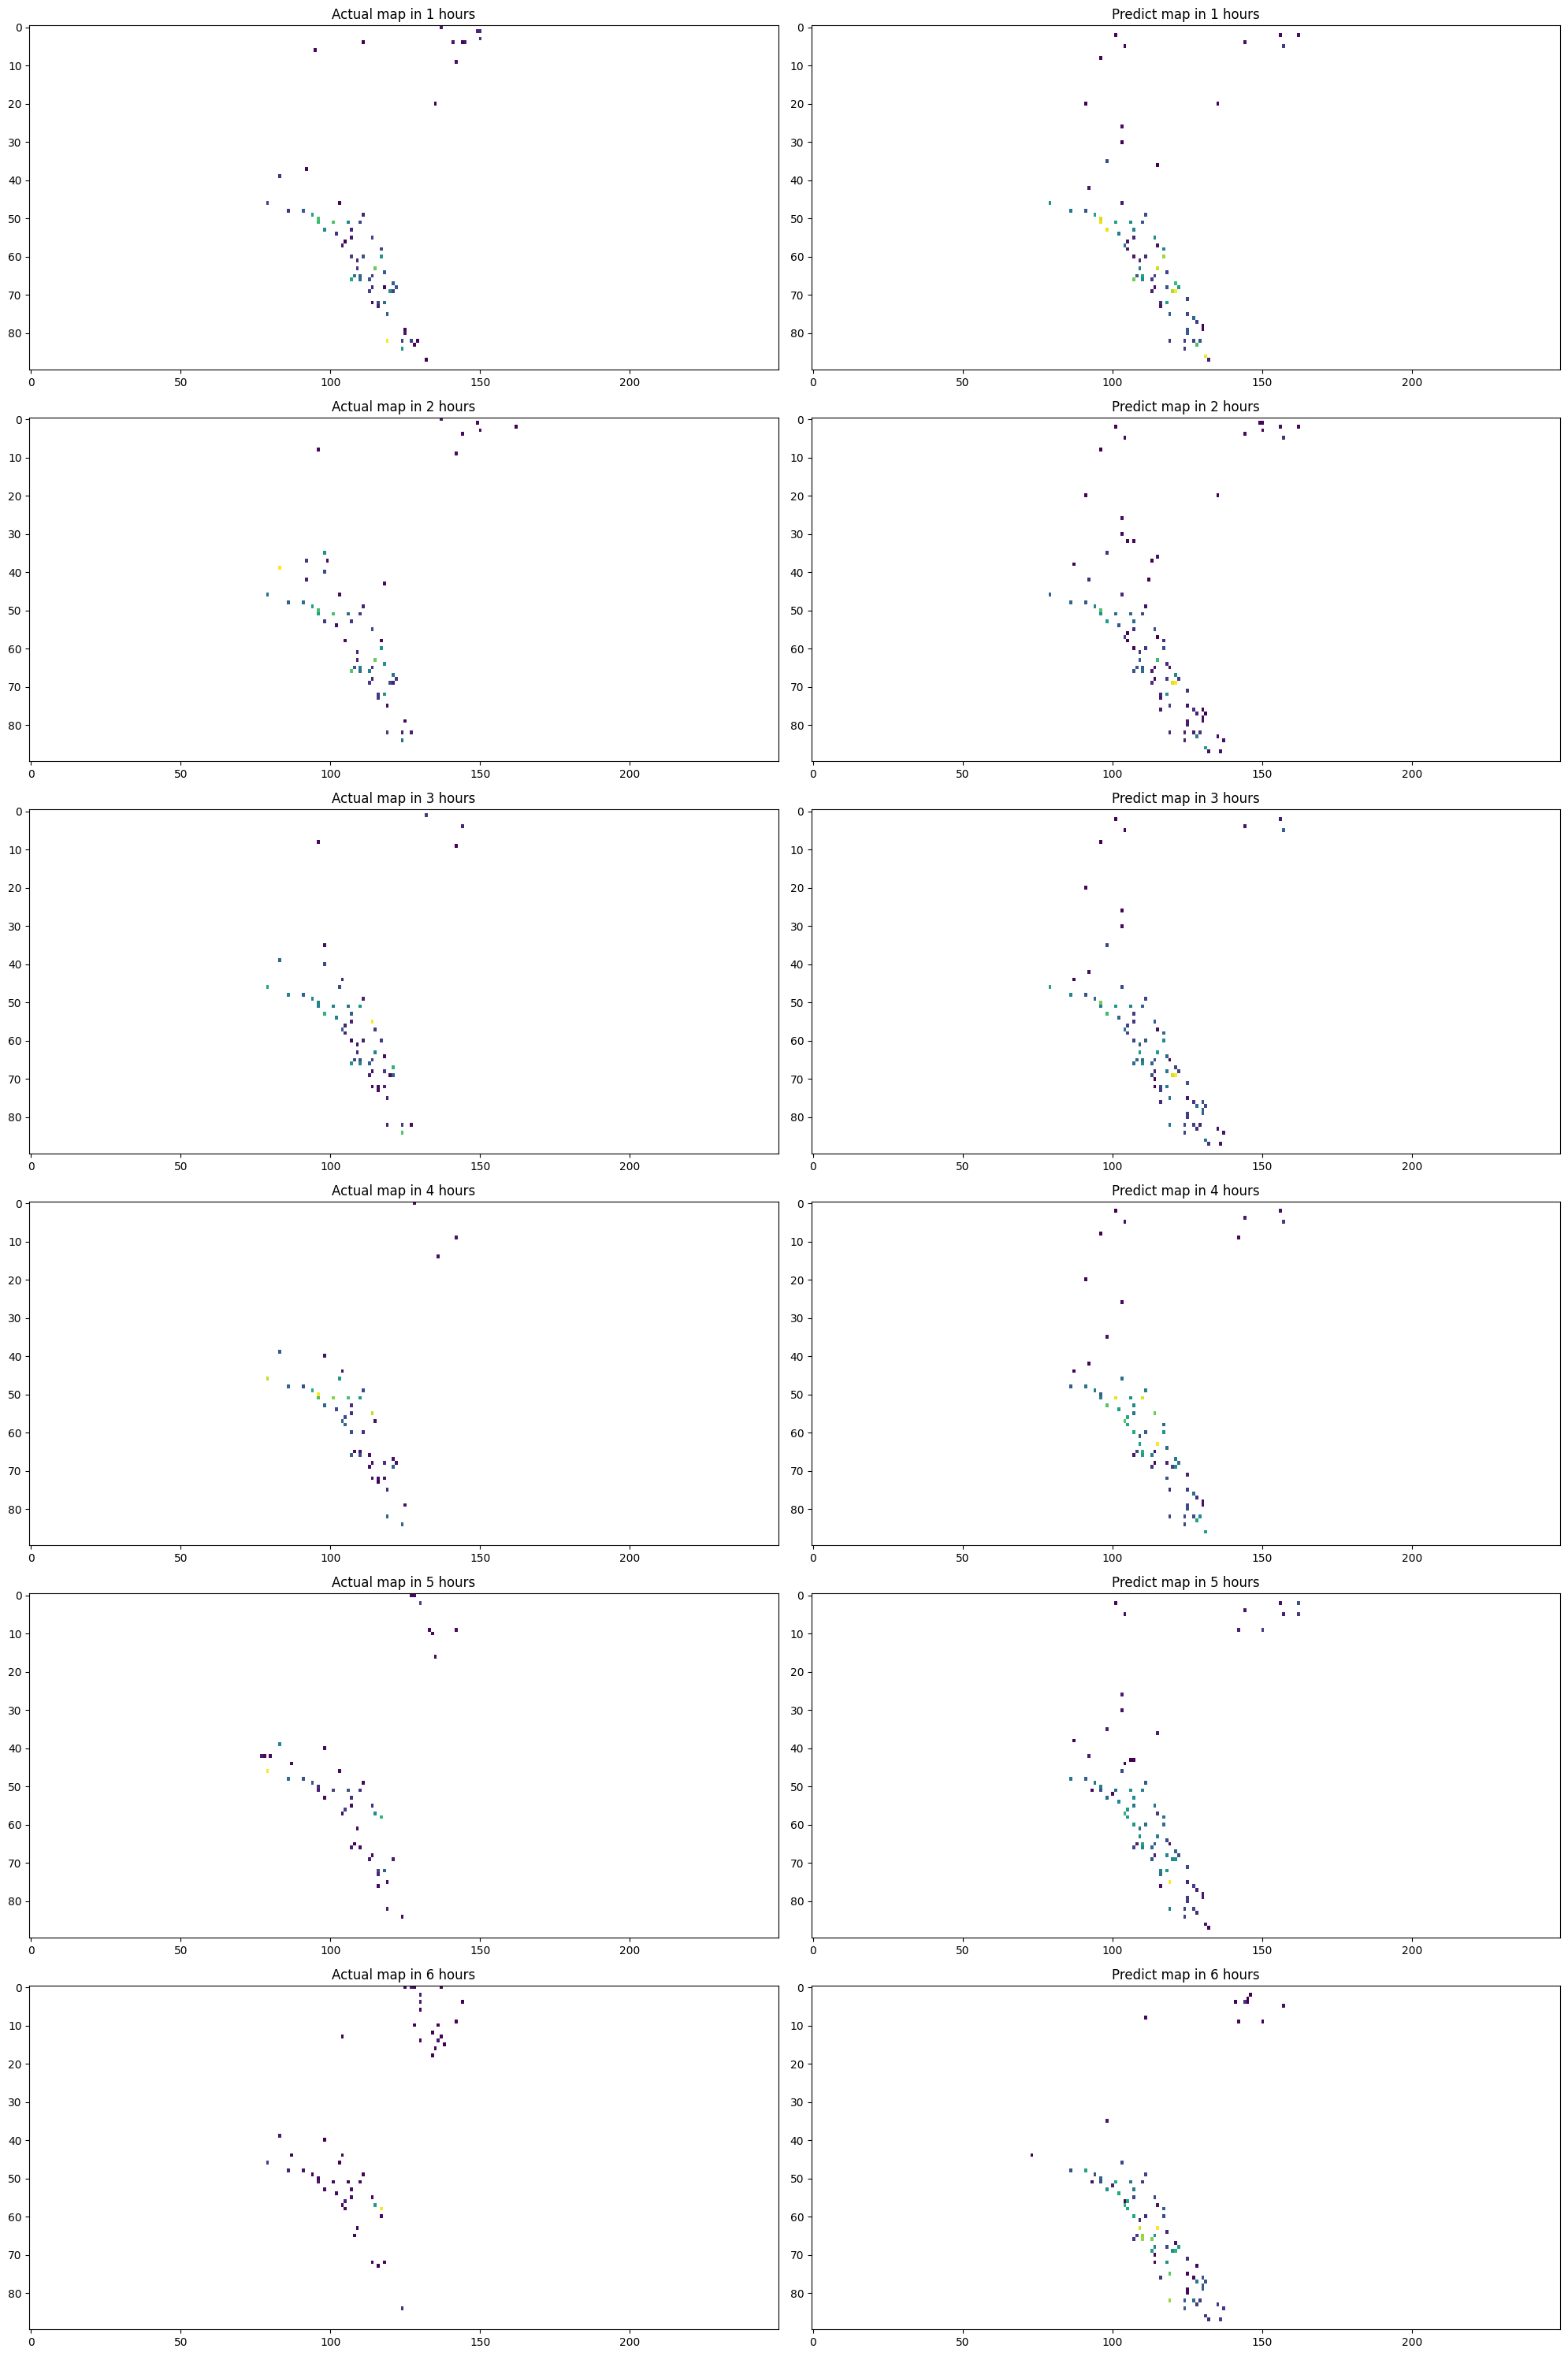

In [146]:
tmp_cor = [(x//WIDTH, x%WIDTH) for x in range(WIDTH*HEIGHT)] 
# print(tmp_cor)
tmp_data = [[[] for _ in range(WIDTH)] for _ in range(HEIGHT)]
start_hour = 4
for i in range(start_hour, start_hour + pre_time_step + aft_time_step):
    read(i,26,10,2020,opt_file_name_path,tmp_cor,tmp_data)
predict_map = np.zeros((aft_time_step,90,250)) 
actual_map = np.zeros((aft_time_step,90,250)) 
for i in range(HEIGHT):
    for j in range(WIDTH):
        if(len(tmp_data[i][j])==pre_time_step+aft_time_step):
            # print(np.array(tmp_data[i][j][:pre_time_step]).shape)
            X_ex = np.array(tmp_data[i][j][:pre_time_step])[:,1:].reshape(1,-1)
            y_ex = np.array(tmp_data[i][j][pre_time_step:])[:,1].reshape(1,-1)
            # print(X_ex[0][0],X_ex[0][10],X_ex[0][20])
            # print(X_ex)
            y_predex = load_model.predict(X_ex)
            # print(X_ex.shape,y_ex.shape, y_predex.shape, aft_time_step)
            for z in range(aft_time_step):
                if aft_time_step == 1:
                    predict_map[z][i][j] = y_predex[z]
                    actual_map[z][i][j] = y_ex[z]
                else:
                    predict_map[z][i][j] = y_predex[0][z]
                    actual_map[z][i][j] = y_ex[0][z]
        # print(tmp_data[i][j])

predict_map[predict_map <= 0.1] = np.nan
actual_map[actual_map <= 0.1] = np.nan
fig, axes = plt.subplots(aft_time_step, 2, figsize=(20, 5 * aft_time_step))
for i in range(0, aft_time_step):
    if aft_time_step == 1:
        axes[0].imshow(actual_map[i], cmap='viridis', aspect='auto')
        axes[0].set_title(f'Actual map in {i+1} hours')
        
        axes[1].imshow(predict_map[i], cmap='viridis', aspect='auto')
        axes[1].set_title(f'Predict map in {i+1} hours')
    else: 
        axes[i, 0].imshow(actual_map[i], cmap='viridis', aspect='auto')
        axes[i, 0].set_title(f'Actual map in {i+1} hours')
        
        axes[i, 1].imshow(predict_map[i], cmap='viridis', aspect='auto')
        axes[i, 1].set_title(f'Predict map in {i+1} hours')
        

plt.tight_layout()  
plt.show()           
# print(X_ex.shape,y_ex.shape)